In [1]:
import QDYN
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from glob import glob
from os.path import join

In [2]:
%matplotlib inline

In [3]:
from src.notebook_plots_v1 import (
    plot_pulse_delta_smoothing, render_pulse_delta_smoothing,
    collect_noise_table, combine_noise_tables, render_pulse_delta_smoothing)
from src.pulse_smoothing_v1 import pulse_delta_smoothing, smooth_pulse_savgol

In [4]:
def rf_sort_key(rf):
    """Key for sorting runfolder according to number of trajectories"""
    try:
        a, b = rf.split('_ntrajs')
        return (a, int(b))
    except ValueError:
        return (rf, 0)

## How does the noise in the optimized pulses scale with the number of trajectories?

In [5]:
ROOT = './data/method_comparison_dicke2_noise/'

In [6]:
rfs_independent_trajs =  sorted(
    glob(join(ROOT, 'T5_independent_ntrajs*')), key=rf_sort_key)

In [7]:
rfs_cross_trajs =  sorted(
    glob(join(ROOT, 'T5_cross_ntrajs*')), key=rf_sort_key)

In [8]:
def rf_pulse_iter(rf):
    pulse1 = QDYN.pulse.Pulse.read(join(rf, 'pulse1.oct.dat'))
    pulse2 = QDYN.pulse.Pulse.read(join(rf, 'pulse2.oct.dat'))
    assert pulse1.oct_iter == pulse2.oct_iter
    return pulse1.oct_iter


In [9]:
rfs_independent_trajs = [
    rf for rf in rfs_independent_trajs if rf_pulse_iter(rf) == 5000]
rfs_cross_trajs = [
    rf for rf in rfs_cross_trajs if rf_pulse_iter(rf) == 5000]

In [10]:
rf_rho = join(ROOT, 'T5_rho_ntrajs1')

In [11]:
noise_table = combine_noise_tables([
    collect_noise_table(
        rfs_independent_trajs, smooth_pulse_savgol,
        window_length=5, polyorder=3),
    collect_noise_table(
        rfs_cross_trajs, smooth_pulse_savgol,
        window_length=5, polyorder=3)],
    ['independent', 'cross'])

In [18]:
noise_table

,ν1 independent,ν2 independent,ν1 cross,ν2 cross
2,0.308018,0.055326,0.422073,0.054965
3,0.254438,0.038950,0.354885,0.048840
4,0.239481,0.036399,0.259226,0.040307
5,0.202613,0.029566,0.320142,0.045000
8,0.173078,0.025502,0.227447,0.037765
10,0.140255,0.021628,0.212188,0.031844
15,0.120147,0.016844,0.187107,0.027317
16,0.126626,0.019089,0.165143,0.026777
20,0.110486,0.017665,0.163933,0.024383
25,0.075086,0.013223,0.155941,0.021501


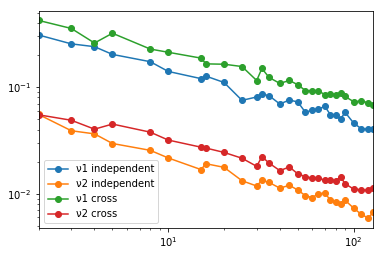

In [12]:
noise_table.plot(logx=True, logy=True, marker='o')
plt.show()

### Power law identification from linear fit

In [13]:
from scipy.stats import linregress

In [14]:
def loglog_linregress(df, col):
    Y = np.log(df[col])
    X = np.log(df.index)
    return linregress(X, Y)

In [15]:
def identify_powerlaw(df):
    slope_s = []
    a_s = []
    err_s = []
    for col in df.columns:
        slope, intercept, _, _, err = loglog_linregress(df, col)
        slope_s.append(slope)
        a_s.append(np.exp(intercept))
        err_s.append(err)
    return pd.DataFrame(OrderedDict([
        ('power', slope_s), ('standard error', err_s),
        ('proportionality factor', a_s)]),
        index=df.columns)

In [16]:
identify_powerlaw(noise_table)

,power,standard error,proportionality factor
ν1 independent,-0.486573,0.013175,0.448214
ν2 independent,-0.486650,0.012374,0.069729
ν1 cross,-0.435165,0.011752,0.571580
ν2 cross,-0.412465,0.011326,0.080082


### Least-Squares Fit to sqrt(M)

In [38]:
from scipy.optimize import minimize_scalar

In [39]:
def alpha_residuals(alpha, X, Y):
    Yhat = alpha / np.sqrt(X)
    delta = Y - Yhat
    return np.dot(delta, delta)

In [40]:
def alpha_least_squares(X, Y):
    res = minimize_scalar(alpha_residuals, args=(X, Y))
    return res.x

In [41]:
alpha_least_squares(noise_table.index, noise_table['ν1 independent'])

0.45695743326325922

In [56]:
(blue, orange, red, green, purple, brown, pink, yellow, lightred, lightblue,
lightorange, lightgreen, lightpurple) = \
('#377eb8', '#ff7f00', '#e41a1c', '#4daf4a', '#984ea3', '#a65628', '#f781bf',
'#d2d215', '#fb9a99', '#a6cee3', '#fdbf6f', '#b2df8a', '#cab2d6')

def plot_alpha_fit(noise_table):
    alpha_ind1 = alpha_least_squares(
        noise_table.index, noise_table['ν1 independent'])
    alpha_ind2 = alpha_least_squares(
        noise_table.index, noise_table['ν2 independent'])
    alpha_cross1 = alpha_least_squares(
        noise_table.index[5:], noise_table['ν1 cross'][5:])
    alpha_cross2 = alpha_least_squares(
        noise_table.index[5:], noise_table['ν2 cross'][5:])
    x = np.linspace(noise_table.index[0], noise_table.index[-1], 10)

    fig, ax = plt.subplots()

    noise_table['ν1 independent'].plot(ax=ax, color=blue)
    ax.plot(x, alpha_ind1 / np.sqrt(x), color=blue, ls='dashed')

    noise_table['ν2 independent'].plot(ax=ax, color=orange)
    ax.plot(x, alpha_ind2 / np.sqrt(x), color=orange, ls='dashed')

    noise_table['ν1 cross'].plot(ax=ax, color=red)
    ax.plot(x, alpha_cross1 / np.sqrt(x), color=red, ls='dashed')

    noise_table['ν2 cross'].plot(ax=ax, color=green)
    ax.plot(x, alpha_cross2 / np.sqrt(x), color=green, ls='dashed')

    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')

    plt.show(fig)

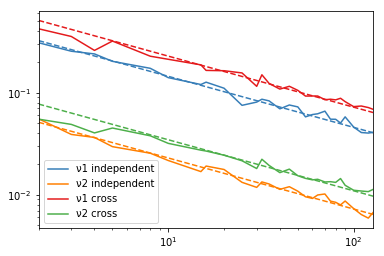

In [57]:
plot_alpha_fit(noise_table)


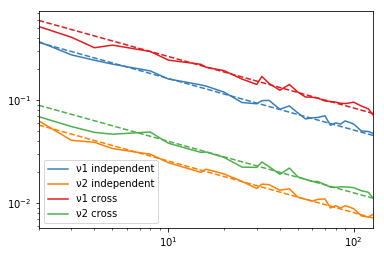

In [61]:
plot_alpha_fit(
    combine_noise_tables([
        collect_noise_table(
            rfs_independent_trajs, smooth_pulse_savgol,
            window_length=9, polyorder=4),
        collect_noise_table(
            rfs_cross_trajs, smooth_pulse_savgol,
            window_length=9, polyorder=4)],
        ['independent', 'cross']))